In [2]:
import mlflow

In [1]:
from digipat.quickstart import *

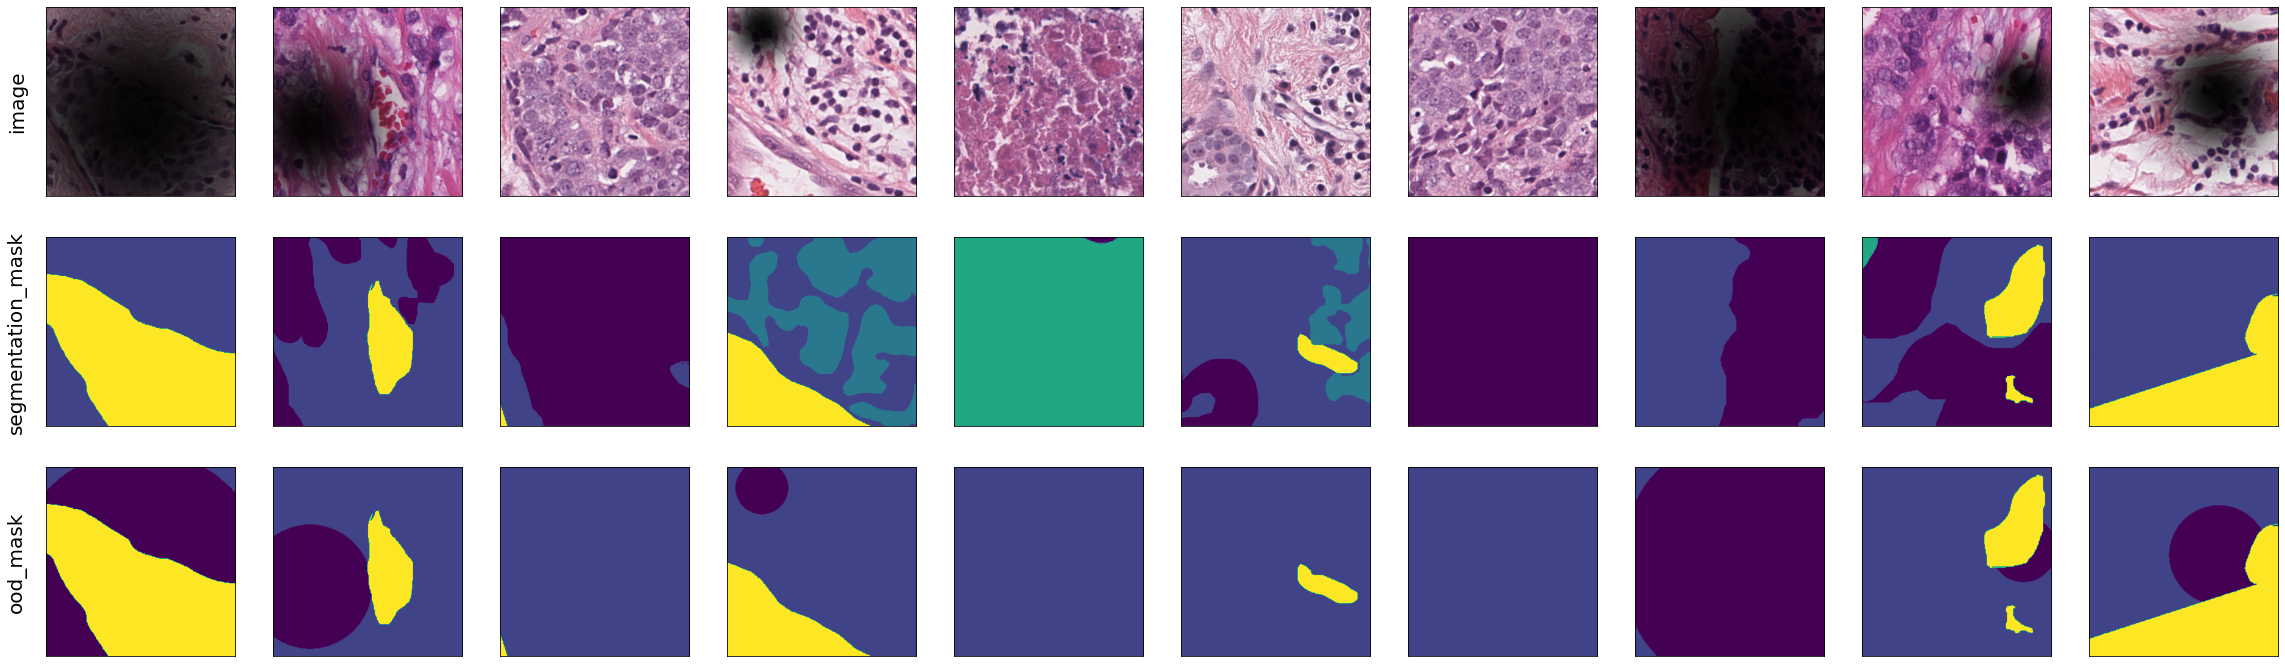

OOD Evaluation: 100%|██████████| 70/70 [00:48<00:00,  1.45it/s]


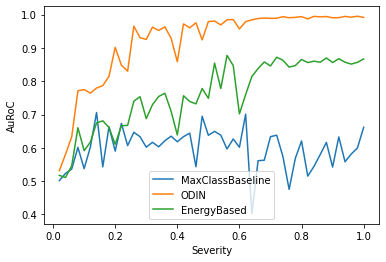

Name                               AUC
----------------------------  --------
OOD_SCORE.0_MaxClassBaseline  0.587573
OOD_SCORE.1_ODIN              0.852714
OOD_SCORE.2_EnergyBased       0.709229


'\n\ncomponent = DatasetOODEvaluationComponent(\n    [BCSS_Adapted_Cropped_Resized_Datasets().val],\n    [BCSS_Adapted_Cropped_Resized_Datasets().test],\n    net,\n    seed=4321\n)\n\ncomponent()\n'

In [3]:
from digipat.models.segmentation import SegmentationModel
from digipat.data.datasets.examples.bcss import (
    BCSS_OOD_Dataset,
    BCSS_Base_Dataset,
    BCSS_Adapted_Datasets,
    BCSS_Adapted_Cropped_Resized_Datasets,
)
from digipat.data.datasets.interfaces import OODDataset
from digipat.ood.augmentations import *
from digipat.data.metadata import SampleMetadataCommonTypes
from digipat.data.container import MetadataContainer
from digipat.ood.metrics import OODAuRoC, infer_container
from digipat.ood.strategies import AugmentationStrategy, OODDatasetsStrategy
from digipat.ood.methods import ODIN, EnergyBased, MaxClassBaseline
from digipat.ood.augmentations.utility.pipeline import SizeInOODPipeline
from digipat.ood.augmentations.indistribution import InResize, InCrop
from digipat.ood.augmentations.pathology.deforming import OverlapAugmentation
from digipat.experiment.components.examples import (
    AugmentationOODEvaluationComponent,
    DatasetOODEvaluationComponent,
)
from digipat.data.datasets.adapter import AlreadyASampleAdapter
from digipat.ood.augmentations.pathology.artifacts.blood_group import (
    BloodGroupAugmentation,
)

import matplotlib.pyplot as plt
import tqdm
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, ConcatDataset


net = SegmentationModel().load()
metrics = [OODAuRoC(group_by="bin", num_bins=50), OODAuRoC()]


component = AugmentationOODEvaluationComponent(
    BCSS_Adapted_Cropped_Resized_Datasets().val,
    SampledOODAugmentation(DarkSpotsAugmentation()),
    net,
    metrics=metrics,
    seed=4321,
)


component()
"""

component = DatasetOODEvaluationComponent(
    [BCSS_Adapted_Cropped_Resized_Datasets().val],
    [BCSS_Adapted_Cropped_Resized_Datasets().test],
    net,
    seed=4321
)

component()
"""


In [13]:
t = component.get_artifacts()["metrics"][0]
np.array(list(t.metric.group_keys)) / (50) + 1/ 50

array([0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22,
       0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44,
       0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66,
       0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88,
       0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ])

In [10]:
import pickle
data = pickle.load(open("filename.pickle", "rb"))

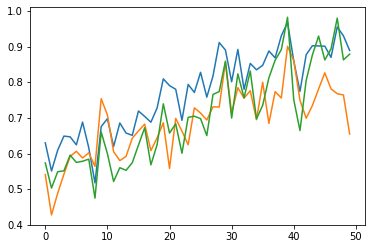

In [13]:
data.metric.present()

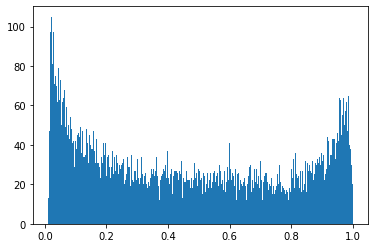

In [6]:
print(np.mean(score,tuple(range(1, score.ndim))))
all.extend(
[
    m["severity"].measurement
    for m in meta
    if m.type is DistributionSampleType.AUGMENTATION_OOD_DATA
] )

import numpy as np
plt.hist(all, 500)
plt.show()
